# Extracting material properties from the Lennard Jones Potential


The Lennard Jones potential is an empirical potential that has been extensively used to model how the potential of two atoms varies as a function of their inter-atomic distance. 

The potential consists of two parts, an attractive term due to van der Wall forses that tends to have a $r^{-6}$ relation and the Pauli repulsive term that dominates at short distances. The repulsive term is technically supposed to be an exponential function, however, at the time this was computationally too demanding and a cheaper approximation was to square the attractive term, hence the Lennard Jones potential took its form:

$U_{LJ}(r) = 4\varepsilon \Big(\frac{\sigma}{r^{12}}-\frac{\sigma}{r^{6}}\Big)$

Where the equilibrium distance $r_0 = 2^{1/6}\sigma$ and the potential energy $V(r_0) = -\varepsilon$. 
A more physically accurate potential is thus the Buckingham potential, that takes the form:

$U_B(r) = A \cdot \text{exp}(-B r) - \frac{C}{r^{6}}$

First of all we will see how good of an approximation the Lennard Jones and the Buckingham potentials are in describing the $H_2$ interatomic potential, by fitting it to the energy potential that we calculate via an `ab initio` method.

How we are going to calculate the potential from first principles is beyond the course, but for curiosity sake I will give a very brief overview:

We are going to use Density functional theory (DFT) to calculate the energy of two atoms as a function of their inter-atomic distance. In order to solve the multi body Schrodinger equation, DFT deals with electron densities rather than individual electrons. For this formulism Kohn and Sham won the [Nobel prise in chemistry in 1998](https://www.nobelprize.org/uploads/2018/06/kohn-lecture.pdf). This assumption tends to work very well, where the only approximations taken are the Born-Oppenhimer approximation and the function used to calculate the exchange-correlation functional. To carry out our DFT calculations we are going to use a Python package called [PySCF](https://pyscf.org/index.html).

Because these calculations are pretty computationally expensive (especially to run on a laptop), we are also going to assume that our potential is continous and smooth and interpolate our data points using a Gaussian process (GP). To accuratly describe the functional with as few evaluations as possible, we are also going to use Bayesian optimisation by using our previously sampled data points as a prior and calculate the expected improvement to determine where to sample next. 

**N.B. that this notebook is supposed to give an overview how various material properties are related to their atomic structure. The actual numerical values extracted are unlikely to be correct due to the toy model and simplified assumptions used.**

In [1]:
# Required python packages (uncomment and run to install all necessery packages)
# ! pip install numpy
# ! pip install matplotlib
# ! pip install scipy
# ! pip install pyscf
# ! pip install scikit-optimize
# ! pip install pymc3
import numpy as np
import matplotlib.pylab as plt
from pyscf import gto, scf, dft
import skopt as sk
import pymc3 as pm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, RationalQuadratic
from scipy.optimize import curve_fit
from scipy.stats import norm

In [80]:
# Conversion parameters
Bohr_to_A = 0.529177249  # conversion of 1 Bohr to Amstrong
Hartee_to_eV = 27.2114  # Conversion of 1 Hartree to eV

# Determine function that given atomic spacing between atoms caluclates the total energy of the system
def E_r(r):
    mol = gto.M(atom = 'H 0 0 0; H 0 0 '+str(r[0]) , basis = '3-21G')
    mf = dft.UKS(mol)
    mf.grids.level = 5
    mf.xc = 'b3lyp, b3lyp' # Exchange correlation potential
    mf = mf.newton() # second-order algortihm
    return mf.kernel()

def E_c():
    mol = gto.M(atom = 'H 0 0 0', basis = '3-21G', symmetry = True, spin = 1)
    mf = dft.UKS(mol)
    mf.grids.level = 5
    mf.xc = 'b3lyp, b3lyp' # Exchange correlation potential
    mf = mf.newton() # second-order algortihm
    return mf.kernel()*2

# Lennerd Johns potential
def U_LJ(r, e, sig, c):
    return 4*e*((sig / r)**12 - (sig / r)**6)

# Buckingham potential
def U_B(r, A, B, C):
    return A * np.exp(-B*r) - C / np.power(r,6)

# Quadratic potential
def quadratic(r, a, b):
    return a*r**2 + b

# Calculate potential using DFT and GP with Bayesian optimisation to estimate where to measure next
def potential(min_r, max_r, n):
        
    # Setting up parameters
    rs = np.linspace(min_r, max_r, 10**3)*Bohr_to_A
    # From LJ we know that a 12th order polynomial should fit the data, so that's what we use as our Kernel
    gp = GaussianProcessRegressor(RationalQuadratic()*DotProduct()**2) 
    
    # Bayesian optimisation to find minimum
    # Initially it takes 5 evenly spaced samples within our range.
    # It then fits a GP to the data and uses expective improvement to decide where to sample next
    # This is done for n iterations, or until the std tends to zero 
    
    e = []
    r = np.linspace(min_r, max_r, 5)*Bohr_to_A
    for i in range(5):
        e = np.append(e, E_r([r[i]]))
        
    gp.fit(r.reshape(-1, 1), e)
    p, std = gp.predict(rs.reshape(-1, 1), return_std=True)
    mask = std > 1e-3
    ind = Acquisition(p, std, mask)       
    for i in range(n):
        if np.mean(std)<10**-5:
            print('std is below threshold')
            break
        r = np.append(r, rs[ind])
        e = np.append(e, E_r([r[-2]]))
        e = np.append(e, E_r([r[-1]]))
        gp.fit(r.reshape(-1, 1), e)
        p, std = gp.predict(rs.reshape(-1, 1), return_std=True)
        mask = std > 1e-6
        ind = Acquisition(p, std, mask)
        plt.figure()
        plt.scatter(r[:-2], e[:-2], c='k')
        plt.scatter(r[-2:], e[-2:], c='r')
#         plt.fill_between(rs, p-std, p+std, color='k', alpha=0.3)
        plt.plot(rs, p, c='k', linestyle='--')       
        if np.any(ind) == None:
            break
    ind = np.argsort(r)
    r, e = r[ind], e[ind] - p[-1]
   
    return r.flatten(), e, rs, p-p[-1], std 


def Acquisition(mean, std, mask, y_opt=0, xi=0.1):
    """
    Expected Improvement acquisition function (from skopt)
    :param mean: predicted average value
    :param std: mse of predicted value
    :param mask: values within which to explore 
    :param y_opt: Previous minimum value which we would like to improve upon. Default zero
    :param xi: Controls how much improvement one wants over the previous best values.
    :return: Acquisition function that we want to maximise
    """
#     explore, exploit = np.zeros_like(mean), np.zeros_like(mean)
#     improve = y_opt - xi - mean[mask]
#     scaled = improve / std[mask]
#     cdf = norm.cdf(scaled)
#     pdf = norm.pdf(scaled)              
#     exploit[mask] = cdf*mean[mask]
#     explore[mask] = std[mask] * pdf
    try:              
        ind_t = np.argmax(std[mask])
        ind_e = np.argmin(mean[mask])
        ind = np.append(ind_t, ind_e)
    except ValueError:
        ind = None
    
    return ind

converged SCF energy = 1.5197180638999  <S^2> = 0  2S+1 = 1
converged SCF energy = -1.91575353874101  <S^2> = 0  2S+1 = 1
converged SCF energy = -1.89191455791115  <S^2> = 0  2S+1 = 1
converged SCF energy = -1.74683935654547  <S^2> = 1.0347279e-13  2S+1 = 1
converged SCF energy = -1.63505953430251  <S^2> = 6.8833828e-14  2S+1 = 1
converged SCF energy = -1.68197079436336  <S^2> = 1.4166446e-13  2S+1 = 1
converged SCF energy = -1.93860216449992  <S^2> = 8.8817842e-16  2S+1 = 1
converged SCF energy = -1.81841276473639  <S^2> = 1.5543122e-15  2S+1 = 1
converged SCF energy = -1.93548541251741  <S^2> = -4.4408921e-16  2S+1 = 1


/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


converged SCF energy = -1.04982862973037  <S^2> = 1.110223e-15  2S+1 = 1
converged SCF energy = -1.94532241645798  <S^2> = 0  2S+1 = 1


/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


converged SCF energy = -1.66279219208011  <S^2> = 1.1413093e-13  2S+1 = 1
converged SCF energy = -1.94010088945114  <S^2> = 4.4408921e-16  2S+1 = 1
converged SCF energy = -1.71393603636326  <S^2> = 1.5276669e-13  2S+1 = 1
converged SCF energy = -1.95334715346464  <S^2> = 0  2S+1 = 1


/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


converged SCF energy = -1.55733703054196  <S^2> = 1.7763568e-15  2S+1 = 1
converged SCF energy = -1.79169072702549  <S^2> = 4.4408921e-16  2S+1 = 1


/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


converged SCF energy = -1.83340462520247  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -1.94551669226406  <S^2> = 1.3322676e-15  2S+1 = 1


/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


converged SCF energy = -0.566802478391005  <S^2> = 0  2S+1 = 1
converged SCF energy = -0.497197512021248  <S^2> = -4.4408921e-16  2S+1 = 1


/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


converged SCF energy = -1.89948229789352  <S^2> = 0  2S+1 = 1
converged SCF energy = -1.80040834645333  <S^2> = -4.4408921e-16  2S+1 = 1


/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


converged SCF energy = -1.19160223735112  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -1.14292412201943  <S^2> = -8.8817842e-16  2S+1 = 1


/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/giovanni/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


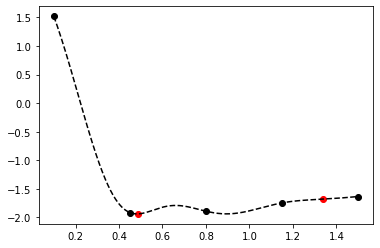

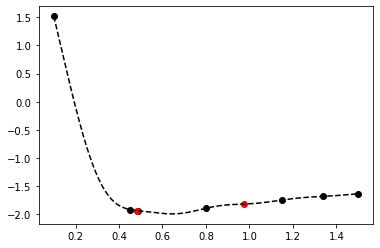

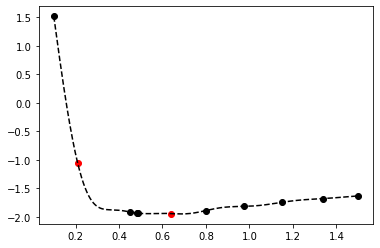

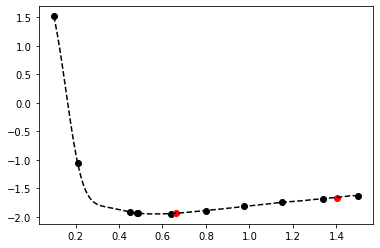

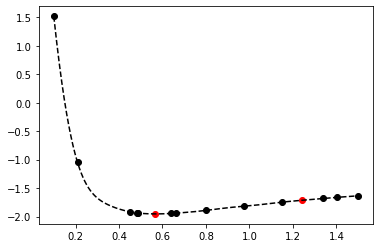

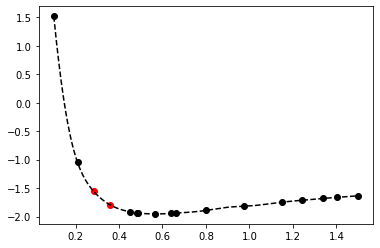

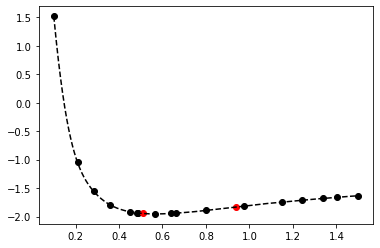

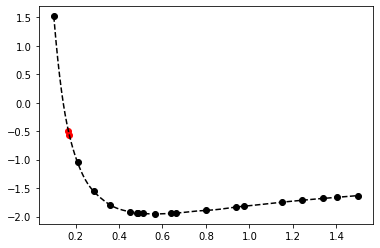

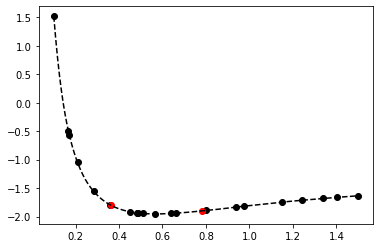

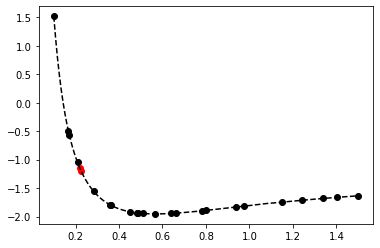

In [81]:
# Evaluating H2 potential using DFT (this will take some time to run)
r, e, rs, p, std = potential(0.1/Bohr_to_A, 1.5/Bohr_to_A, 10)

## Fitting Lennard Johns potential

Text(0, 0.5, ' E (eV)')

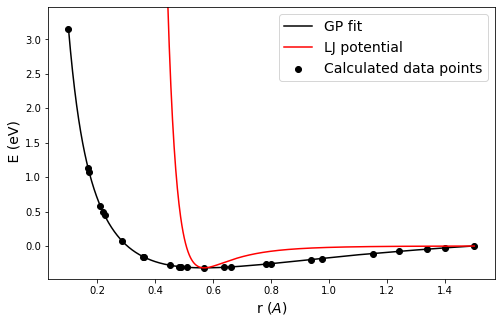

In [82]:
# LJ potential
sig = rs[np.argmin(p)]/2**(1/6)
guess = np.array((-np.min(p-p[-1]), sig, p[-1]))

# plot data
plt.figure(figsize=(8,5))
plt.scatter(r, e, c='k')
plt.plot(rs, p, c='k')

plt.plot(rs, U_LJ(rs, *guess), c='r')
plt.ylim(np.min(p)*1.5, np.max(p)*1.1)

plt.legend(('GP fit', 'LJ potential', 'Calculated data points'), fontsize=14)
plt.xlabel('r ($A$)', fontsize=14)
plt.ylabel(' E (eV)', fontsize=14)

As we can see, the LJ potential struggles to fit the DFT data, even though qualitativly it shows the correct relationship, as in we have a repulsive term at vary short lenghtscales and an attractive term above $r_0$.

The reason why it fails is because it assumes that there is only a Wan der Wall attractive force, which for $H_2$ is not the case, as we see in the wider well present. Also the repulsive term is incorrect, as this should be an exponential. Let's see if the Buckhingham potential can do better at least in the short lengthscales.

Text(0, 0.5, ' E (eV)')

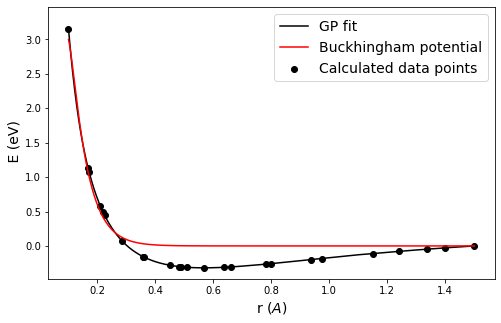

In [83]:
guess = np.array((-10, 1, -0.1))
fit, cov = curve_fit(U_B, rs, p, guess)

plt.figure(figsize=(8,5))
plt.scatter(r, e, c='k')
plt.plot(rs, p, c='k')

plt.plot(rs, U_B(rs, *fit), c='r')

plt.ylim(np.min(p)*1.5, np.max(p)*1.1)

plt.legend(('GP fit', 'Buckhingham potential', 'Calculated data points'), fontsize=14)
plt.xlabel('r ($A$)', fontsize=14)
plt.ylabel(' E (eV)', fontsize=14)

As we can see, the Buckhingham potential is able to fit the repulsive term, but underestimates the bonding energy, as it assumes only van der Wall interactions

# Mechanical properties:

From the potential energy, we can take the derivative to obtain the force of our system. At the equilibrium point, as a first approximation the potential can be approximated as a quadratic potential. This results in a linear term relative to displacement, i.e. we obtain Hook's law:

$ F = - k x$

If this is the case, we expect that $\frac{\delta U}{\delta r}$ should therefore be roughly a constant at $r_0$

If instead we differentiate again, we obtain the stiffness of our material, or should we say its Young's modulus. We are thus going to extract these parameters from our DFT potential.

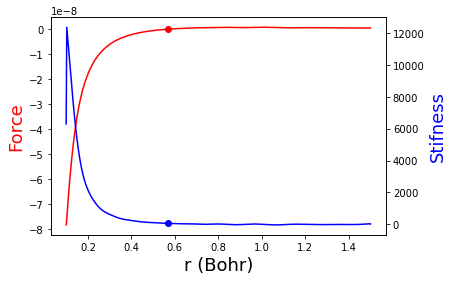

Hook's constant: 2.0782941558489618e-12 N/m
Young's modulus: 63.37366294784121 Pa


In [84]:
# Numerical differentiation to obtain the force and stifness
index = np.argmin(p)
F = np.gradient(p*1.6021*10**-19, rs*10**-10)
S = np.gradient(F, rs*10**-10)
k = abs(F[index])
E = S[index]

fig,ax = plt.subplots()
ax.plot(rs, F, color="red")
ax.scatter(rs[index], F[index], c='r')
# set x-axis label
ax.set_xlabel("r (Bohr)",fontsize=18)
# set y-axis label
ax.set_ylabel("Force",color="red",fontsize=18)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(rs, S, color="blue")
ax2.scatter(rs[index], S[index], c='b')
ax2.set_ylabel("Stifness",color="blue",fontsize=18)
plt.show()

print("Hook's constant: "+str(k)+" N/m")
print("Young's modulus: " + str(E)+ " Pa")

If we want to carry out the same calculations for a crystalline material, say for instance diamond, we would have to calculate the ground state energy for various lattice parameters within the unit cell. This would be computationally too expensive to carry out on a laptop, but it can be done. Also, due to the symmetry of a crystal, the mechanical properties could be anysotropic, and thus our Young's modulus becomes a matrix, rather than a single parameter.

In order to model a crystal, DFT codes adopt periodic boundary conditions with a plane wave basis set. This way you would only need to simulate a the unit cell of your material.

A more detailed review of how this can be done in practice can be found [here](https://pubs.rsc.org/en/content/articlehtml/2021/ce/d1ce00453k)

# Phonon properties

From our classical picture of discribing our two atoms being bonded by a spring. We can then imagine that if we purturbed the system it would oscillate from its equilibrium position. In particular, as a first approximation we can model this as simple harmonic motion. 

The periodic vibrations that a crystalline material can experience are know as phonons, which will have specific natural frequencies $\omega$, which for simple harmonic motion will be: $\omega = \sqrt{\frac{k}{m}}$, which we can calculate as we have an estimate for k.

If instead we have a chain of atoms in 1D, then classically the vibration frequencies can be described as:

$\omega = \sqrt{\frac{2k}{m}(1-cos(qr_0)}$

Where k is our Hook's constant, m is the mass of the atom, $q$ is our reciprical wavenumber and $r_0$ is our equilibrium radius. Therefore, if we have a 1D chain of hydrogen atoms, we would have as our phonon density of states:

Text(0, 0.5, '$\\omega$ (MHz)')

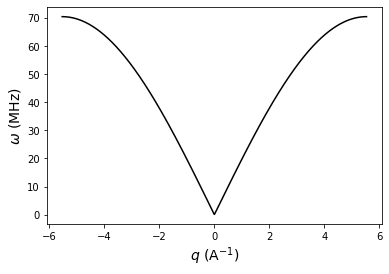

In [85]:
m = 1.6726219 * 10**-27 # mass of proton
q = np.linspace(-np.pi/rs[np.argmin(p)], np.pi/rs[np.argmin(p)], 10**3)
omega = np.sqrt(2*k/m*(1-np.cos(rs[np.argmin(p)]*q)))
plt.plot(q, omega/10**6, c='k')
plt.xlabel('$q$ (A$^{-1}$)', fontsize=14)
plt.ylabel('$\omega$ (MHz)', fontsize=14)

From the slope of the phonon density of states at $q\sim0$, we have roughly a linear relationship, where the slope of the curve is related to the speed of sound in the material, which we can extract as:

In [86]:
print('Speed of sound: ' +str(np.polyfit(omega[500:600], q[500:600]*10**10, 1)[0]) + ' m/s')

Speed of sound: 506.8637523355513 m/s


The classical model that we have used here only takes nearest neighbours into account and approximates our potential as being a simple parabola, thus neglecting anharmonic terms in the oscillations. Hiwever, for small wavenumbers $q$ it aggrees relatively well. Also in a crystalline material, we will have differences in $\omega$ depending on the reciprical direction that we take, as dictated by the crystal structure.

# Thermodynamic properties:

Once we have our values of $\omega_{\nu}$, we can calculate the total energy of our system as 

$E_{tot}=U_0 + \sum_{nu} \frac{\hbar \omega_{\nu}}{2}$

We can then determine the probability of an atom $i$ in our material having a certain energy at a particular temperature $T$ as:

$P_i = \frac{1}{Z} exp \Big(-\frac{E_{tot, i}}{k_B T}\Big)$

Where $Z$ is the partition function, that is defined as:

$Z = \sum_i exp\Big(-\frac{E_{tot, i}}{k_B T}\Big)$

We can then calculate the enthalpy $H$ at a given temperature as:

$H = <E_{tot}>_T + pV$ where $p = k_BT\frac{\delta}{\delta V} ln(Z)$

And the entropy can be calculated as:

$S = -k_B \sum_i P_i ln(P_i)$

So putting everything together and simplifying, we can obtain the Gibbs enerfy as:

$G = -k_BT\Big(1 - V\frac{\delta}{\delta V}ln(Z)\Big)$

Since we need more than one vibrational frequency $\omega_{\nu}$ to get a non zero entropy, we are going to extract the vibrational frequencies for $H_2$, which we expect to be three in total (along x, y and z)

In [87]:
from pyscf import gto, scf, eph

r0 = rs[np.argmin(p)]

mol = gto.M(
atom = [['H', [0.000000000000,  0,   0]],
        ['H', [0,  0,   r0]]],
    
basis = '3-21G',
unit = 'Amstrong'
)
# Note that this is a pre-computed relaxed molecule
mf = dft.UKS(mol)
mf.grids.level = 5
mf.xc = 'b3lyp, b3lyp' # Exchange correlation potential
mf = mf.newton() # second-order algortihm
mf.kernel()

myeph = eph.EPH(mf)
ephmat, omega_nu = myeph.kernel()

converged SCF energy = -1.95335005719507  <S^2> = 4.4408921e-16  2S+1 = 1


Text(0, 0.5, 'Gibbs energy (J)')

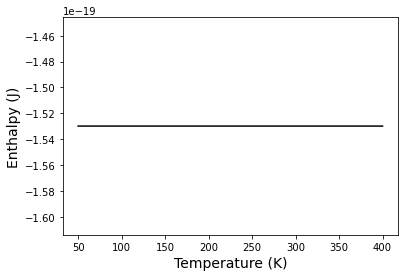

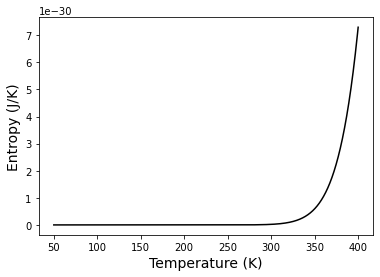

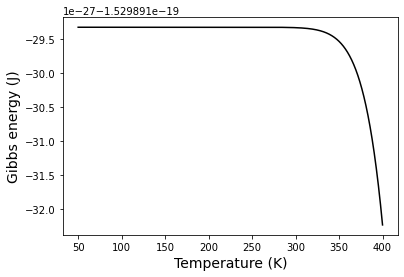

In [88]:
hbar = 1.0545718 * 10**-34  # REduced Plank's constant
kb = 1.38064852 * 10**-23   # Boltzman constant

T = np.linspace(50, 400, 10**4)  # Temperature range in K (function tends to explode close to 0 K)

E_t = np.min(p)*1.6022*10**-19 + hbar*omega_nu/2  # total energy
Z = np.exp(-np.sum(E_t)/kb/T)  # partition function

# Probability
P = np.zeros((len(omega_nu), len(T)))  
for i in range(len(omega_nu)):
    P[i] = 1/Z * np.exp(-E_t[i]/kb/T)

S = -kb*np.sum(P*np.log(P), axis=0)  # Entropy
H = np.sum(E_t) + kb*T*E*r0*10**-10*np.log(Z)  # Entholpy

G = H - T*S

plt.figure()
plt.plot(T, H, c='k')
plt.xlabel('Temperature (K)', fontsize= 14)
plt.ylabel('Enthalpy (J)', fontsize= 14)

plt.figure()
plt.plot(T, S, c='k')
plt.xlabel('Temperature (K)', fontsize= 14)
plt.ylabel('Entropy (J/K)', fontsize= 14)

plt.figure()
plt.plot(T, G, c='k')
plt.xlabel('Temperature (K)', fontsize= 14)
plt.ylabel('Gibbs energy (J)', fontsize= 14)

As we can see, the enthalpy does not change much with temperature, while the entropy is much more susceptable to temperature changes. We also notice that the Gibbs energy is negative within this temperature range, suggesting that the molecule is thermodynamically stable. In order to then calculate a phase diagram, these type of calculations would neeed to be carried out for all the different polymorths and compositions to then be able to obtain the Gibbs free energy curves required to construct a phase diagram.